In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem, ML
from rdkit.Chem import AllChem
from rdkit.ML import Scoring
from rdkit.ML.Scoring import Scoring
from rdkit.ML.Scoring.Scoring import CalcAUC, CalcBEDROC, CalcEnrichment
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 100

> Give an overview of the dataset you have chosen to use.
>
>    - What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
>    - Who collected the data? Why? When?
>    - What evaluation criteria will you be using and why? 


MySQL Query used to create the "raw" data from chemBL - note that we do filter to IC50 standard type and nM for our standard units as our only transformations prior to bringing this data into a Python Environment.  We do this to limit the size of the data ingested.  Additionally, we select on choice columns from our first table (Activities) as these columns we believed to be most important and all other columns to be irrelevant or redundant.
```
SELECT  a.activity_id,
		a.assay_id,
        a.doc_id,
        a.record_id,
        a.molregno,
        a.standard_relation,
        a.standard_value,
        a.standard_units,
        a.standard_flag,
        a.standard_type,
        a.pchembl_value,
        b.*,
        c.*,
        d.*,
        e.canonical_smiles
-- output data
INTO OUTFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/result.tsv'
FIELDS TERMINATED BY '\t' OPTIONALLY ENCLOSED BY '"'
LINES TERMINATED BY '\n'
FROM chembl.activities a

-- Join on ligand table
inner join chembl.ligand_eff b
on a.activity_id = b.activity_id

-- Join on Compound Properties
inner join chembl.compound_properties c
on a.molregno = c.molregno

-- Join on Assays
inner join chembl.assays d
on a.assay_id = d.assay_id

-- Join on Compound Properties for the Smiles
inner join chembl.compound_structures e
on a.molregno = e.molregno

where a.standard_type = 'IC50' and a.standard_units = 'nM';
```

In [2]:
# read in data
df = pd.read_csv("chemBL.csv")

In [3]:
# print length and show sample data
print(len(df))
df.head()

562960


,standard_value,le,target_type,pref_name,canonical_smiles,molecular_species
0,17000.0,0.20,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC...,NEUTRAL
1,180.0,0.25,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,NEUTRAL
2,29.4,0.43,SINGLE PROTEIN,Beta-1 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
3,30.8,0.43,SINGLE PROTEIN,Beta-2 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
4,120.0,0.56,PROTEIN COMPLEX GROUP,GABA-A receptor; anion channel,CCOC(=O)c1cn2c(n1)sc1ccccc12,NEUTRAL


In [4]:
# binarize ligand values based on ranges <=300 nM and >=10000 nM (1 for active, 0 for inactive respectively)
df.loc[df["standard_value"] <= 300.0, "standard_value_bin"] = 1
df.loc[df["standard_value"] >= 10000.0, "standard_value_bin"] = 0

In [5]:
# filter out where molecular species is null as molecular species is either base, neutral, or acidic
df = df[~df["molecular_species"].isnull()]

In [6]:
# determine the assay count by target name
targets = df.groupby("pref_name")[["target_type"]].agg({"target_type": "count"}).sort_values(by="target_type", ascending=False)

targets["cumulative_count"] = targets["target_type"].cumsum()

targets["cumulative_perc"] = targets["cumulative_count"]/sum(targets["target_type"])

targets = targets[targets["cumulative_perc"] <= 0.8]

targets.iloc[:100]

df = df[df["pref_name"].isin(targets.iloc[:100].index)]

In [7]:
# CHATGPT GENERATED CODE
# Define a function to generate fingerprints
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
    features = np.zeros((1,))
    Chem.DataStructs.ConvertToNumpyArray(fp, features)
    return features

# def generate_maccs(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     fp = MACCSkeys.GenMACCSKeys(mol)
#     features = list(fp.GetOnBits())
#     return features

# Apply the function to each row of the DataFrame
df['Fingerprint'] = df["canonical_smiles"].apply(generate_fingerprint)



>[1.0 points] How many tasks or modalities are there in the dataset and how do you define each task or modality? That is, explain if the task is within the same domain, cross domains, etc. If there are too many tasks or modalities to train the data reasonably, select a subset of the tasks for classification. For example, you might want to only train on 50 of the classification tasks.  

(array([33750., 26692., 26618., 19508., 21575., 30528., 26761., 22310.,
        23085., 19142.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

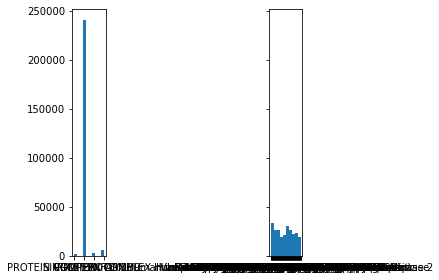

In [8]:
# plot out each set of tasks
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(df["target_type"])
axs[1].hist(df["pref_name"])

In [9]:
task_X_list = []
task_y_list = []

for s in df["pref_name"].unique():
    # example: neutral_X = np.array(df[df["molecular_species"] == "NEUTRAL"]["Fingerprint"].tolist())
    X = np.array(df[df["pref_name"] == s]["Fingerprint"].tolist())
    y = df[df["pref_name"] == s]["standard_value_bin"].values

    task_X_list.append((s, X))
    task_y_list.append((s, y))

In [10]:
# used in case want to concat other datapoints
# np.concatenate((neutral_arr, df[df["molecular_species"] == "NEUTRAL"]["standard_value_bin"].values.reshape(-1,1)), axis=1)

>[1.0 points] Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

Since our dataset has ~250,000 records, we decided to split our data into 80% training, 20% testing. For the generalized model, we need to combine all of the tasks into a single task.

In [11]:
for x,y in zip(task_X_list, task_y_list):
    X_train, X_test, y_train, y_test = train_test_split(x[1], 
                                                        y[1], 
                                                        test_size=0.2, 
                                                        random_state=7)
    all_data = {"data": [], "target": [], "data_test": [], "target_test": []}
    all_data["data"].append(X_train)
    all_data["target"].append(y_train)        
    all_data["data_test"].append(X_test)
    all_data["target_test"].append(y_test)

X_train_all = np.concatenate(all_data["data"])
y_train_all = np.concatenate(all_data["target"])

X_test_all = np.concatenate(all_data["data_test"])
y_test_all = np.concatenate(all_data["target_test"])

>[3.0 points] Train a general model (or per task model) to perform the classification tasks. That is, a general model uses all modalities and all tasks should combined into a single classification task (if possible). Alternatively, if this is not possible, you could create a model for each specific task. For a task specific model, each task would be classified with its own feed-forward model.

In [12]:
from sklearn.metrics import mean_squared_error as sk_mean_squared_error
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error

def bland_altman_plot(data1, data2, *args, **kwargs):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    
    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(sk_mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten



In [14]:
len(X_train_all)

1203

In [ ]:
#TODO: Run model through cv split - refer to lab6,7 for code

In [25]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

generalized_mlp = Sequential()
generalized_mlp.add(Dense(input_dim=X_train_all.shape[1], units=512, activation='relu', name='input_dense512'))
generalized_mlp.add(Dropout(0.2))

generalized_mlp.add(Dense(units=256, activation='relu', name='mid_dense256'))
generalized_mlp.add(Dropout(0.2))

generalized_mlp.add(Dense(units=256, activation='tanh', name='mid_dense2_216'))
generalized_mlp.add(Dropout(0.2))

generalized_mlp.add(Dense(units=128, activation='relu', name='mid_dense128'))
generalized_mlp.add(Dropout(0.2))

generalized_mlp.add(Dense(units=64, activation='tanh', name='mid_dense64'))
generalized_mlp.add(Dropout(0.2))

generalized_mlp.add(Dense(units=32, activation='relu', name='mid_dense32'))
generalized_mlp.add(Dropout(0.2))

generalized_mlp.add(Dense(units=16, activation='tanh', name='mid_dense16'))
generalized_mlp.add(Dense(1, activation='sigmoid', name='output_layer'))

generalized_mlp.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", "AUC"])

generalized_mlp.fit(X_train_all, y_train_all, epochs=200, shuffle=False, verbose=1, validation_data=(X_test_all,y_test_all))
y_hat_general = generalized_mlp.predict(X_test_all)

Epoch 1/200
38/38 [==============================] - 2s 19ms/step - loss: 0.5506 - accuracy: 0.8670 - auc: 0.4900 - val_loss: 0.4696 - val_accuracy: 0.9668 - val_auc: 0.5782
Epoch 2/200
38/38 [==============================] - 0s 8ms/step - loss: 0.4524 - accuracy: 0.9410 - auc: 0.5145 - val_loss: 0.3635 - val_accuracy: 0.9668 - val_auc: 0.6338
Epoch 3/200
38/38 [==============================] - 0s 8ms/step - loss: 0.3754 - accuracy: 0.9485 - auc: 0.5794 - val_loss: 0.2875 - val_accuracy: 0.9668 - val_auc: 0.6646
Epoch 4/200
38/38 [==============================] - 0s 7ms/step - loss: 0.3142 - accuracy: 0.9510 - auc: 0.6342 - val_loss: 0.2350 - val_accuracy: 0.9668 - val_auc: 0.6904
Epoch 5/200
38/38 [==============================] - 0s 8ms/step - loss: 0.2740 - accuracy: 0.9510 - auc: 0.6233 - val_loss: 0.2005 - val_accuracy: 0.9668 - val_auc: 0.7098
Epoch 6/200
38/38 [==============================] - 0s 8ms/step - loss: 0.2502 - accuracy: 0.9510 - auc: 0.5403 - val_loss: 0.1786 - 

In [ ]:
# y_hat_converted = []
# for i in y_hat_general:
#     y_hat_converted.append(i[0])

#don't think we need this anymore.

In [22]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test_all, y_hat_general)
auc

0.775085910652921

In [26]:
from sklearn import metrics as mt

def roc_calc(model, X_test, y_test):
    yhat = model.predict(X_test)
    false_positive, true_positive, _ = mt.roc_curve(y_test.flatten(), yhat.flatten())
    roc = mt.auc(false_positive, true_positive)
    return false_positive, true_positive, roc

In [29]:
# get the average AUC for all models
generalized_mlp_fp, generalized_mlp_tp, generalized_mlp_roc = roc_calc(generalized_mlp, X_test_all, y_test_all)

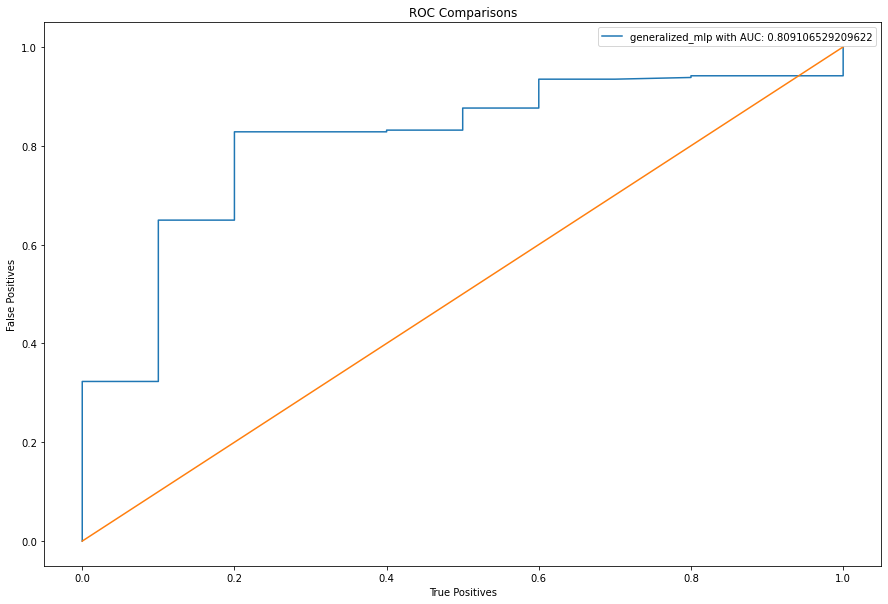

In [30]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(generalized_mlp_fp, generalized_mlp_tp)
plt.plot([0, 1])
plt.ylabel('False Positives')
plt.xlabel('True Positives')
plt.legend([f"generalized_mlp with AUC: {generalized_mlp_roc}"])